In [1]:
from gtda.homology import EuclideanCechPersistence,VietorisRipsPersistence
from gtda.diagrams import PersistenceImage
from gtda.pipeline import Pipeline
from gtda.diagrams import Filtering

In [2]:
import tensorflow as tf
import gudhi as gd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
import scipy.spatial as spatial
import json
from rich import print
from random import choice, sample
from tqdm.notebook import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors
from gc import collect
from pickle import load

with open("9701_cech_persistence_images_012_50x50.pickle", mode = "rb") as data:
    save_dict = load(data)
    train_molecules = save_dict["train_molecules"]
    train_data = save_dict["train_data"]
    
    test_molecules = save_dict["test_molecules"]
    test_data = save_dict["test_data"]
    
%matplotlib inline
del save_dict
collect()

4

In [3]:
print(train_data.shape, test_data.shape)

(7761, 9, 50, 50)
(1940, 9, 50, 50)

for ims in tqdm(train_data):
    for im in ims:
        max_px = im.max()
        assert not (max_px < 0.0)
        if max_px > 0.0:
            im *= 1/max_px
        
for ims in tqdm(test_data):
    for im in ims:
        max_px = im.max()
        assert not (max_px < 0.0)
        if max_px > 0.0:
            im *= 1/max_px

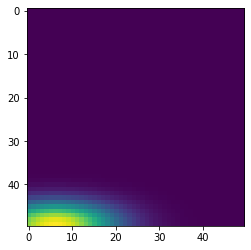

In [4]:
plt.imshow(train_data[19,7])

# Extract descriptors
(this can be done from rdkit or from the descriptor .csv)

In [5]:
df = pd.read_csv("data/Drugbank_some_descriptors.csv")
cntr = 0
for d in df:
    cntr += 1
print(cntr)

126

### Filter descriptors which are unavailable

In [6]:
descriptors = list()

# consider only descriptors which have few missing values and which are floating point
for d in df:
    if df[d].isna().sum() < 800 and df[d].dtype == np.float64:
        descriptors.append(d)

num_descriptors = len(descriptors)
print(descriptors)

# select only smiles which have these descriptor values
train_smiles = set(train_molecules)
test_smiles = set(test_molecules)

for i,d in enumerate(descriptors):
    avail_rows = df[np.logical_not(df[d].isna())]
    train_smiles = set(avail_rows["SMILES"]).intersection(train_smiles)
    test_smiles = set(avail_rows["SMILES"]).intersection(test_smiles)

train_idxs = np.asarray(sorted([ train_molecules.index(t) for t in train_smiles ]))
test_idxs = np.asarray(sorted([ test_molecules.index(t) for t in test_smiles ]))

train_molecules = np.asarray(train_molecules)
train_molecules = train_molecules[train_idxs]
train_data = train_data[train_idxs]

test_molecules = np.asarray(test_molecules)
test_molecules = test_molecules[test_idxs]
test_data = test_data[test_idxs]

[
    'ACD Descriptors;logP',
    'ACD logD-logP;logP',
    'MOE Descriptors;h_ema',
    'MOE Descriptors;h_emd',
    'MOE Descriptors;h_emd_c',
    'MOE Descriptors;h_logp',
    'MOE Descriptors;h_logs',
    'MOE Descriptors;h_log_dbo',
    'MOE Descriptors;h_log_pbo',
    'MOE Descriptors;h_mr',
    'OEselma Descriptors;bromine_count',
    'OEselma Descriptors;carbon_count',
    'OEselma Descriptors;clorine_count',
    'OEselma Descriptors;ertl_tpsa',
    'OEselma Descriptors;fluorine_count',
    'OEselma Descriptors;hba',
    'OEselma Descriptors;hba_lipinski',
    'OEselma Descriptors;hbd',
    'OEselma Descriptors;hbd_lipinski',
    'OEselma Descriptors;halogen_count',
    'OEselma Descriptors;iodine_count',
    'OEselma Descriptors;max_flex_chain_1',
    'OEselma Descriptors;max_flex_chain_2',
    'OEselma Descriptors;max_flex_chain_3',
    'OEselma Descriptors;max_rigid_chain',
    'OEselma Descriptors;mol_volume_2d',
    'OEselma Descriptors;mw',
    'OEselma Descriptors;npsa',
    'OEselma Descriptors;neg_ioniz',
    'OEselma Descriptors;nitrogen_count',
    'OEselma Descriptors;nonpolar_count',
    'OEselma Descriptors;nonpolar_count_per_mw',
    'OEselma Descriptors;rigid_frag_count',
    'OEselma Descriptors;aromatic_ring_count',
    'OEselma Descriptors;atom_count',
    'OEselma Descriptors;bond_count',
    'OEselma Descriptors;rigid_bond_count',
    'OEselma Descriptors;ring_count',
    'OEselma Descriptors;rot_bond_count',
    'OEselma Descriptors;oxygen_count',
    'OEselma Descriptors;psa',
    'OEselma Descriptors;phosphorous_count',
    'OEselma Descriptors;polar_count',
    'OEselma Descriptors;polar_count_per_mw',
    'OEselma Descriptors;pos_ioniz',
    'OEselma Descriptors;silicon_count',
    'OEselma Descriptors;sulphur_count',
    'OEselma Descriptors;tsa',
    'Ertl TPSA;Ertl TPSA',
    'Exact Mass;Exact Mass',
    'Heavy Atom Count;Heavy Atom Count',
    'Molecular Volume (2D);Molecular Volume (2D)',
    'Molecular Weight;Molecular Weight',
    'NPSA;NPSA',
    'PSA;PSA',
    'Ring Count;Ring Count',
    'Rotatable Bond Count;Rotatable Bond Count',
    'AZlogD74;prediction',
    'AZlogD74;sd_prediction',
    'ChromlogD;prediction',
    'ChromlogD;sd_prediction',
    'ALogP',
    'Mol Weight',
    'Molar Refractivity',
    'Polarizability',
    'TPSA',
    'Solubility DD Class;confidence',
    'Solubility DD Class;credibility',
    'SCScore;SCScore',
    'AZlogD74 (NN);nearest_neighbours[]- GT similarity',
    'AZlogD74 (NN);nearest_neighbours[]- GT measured',
    'clogP;clogp',
    'clogP;clogp_error',
    'OEselma Descriptors;part_flex_chain'
]

In [7]:
print(train_data.shape, test_data.shape)

(7190, 9, 50, 50)
(1802, 9, 50, 50)

### Build numpy arrays of descriptors

In [8]:
collect()
train_labels = np.empty((train_data.shape[0], num_descriptors))
test_labels = np.empty((test_data.shape[0], num_descriptors))
train_labels[:] = np.nan
test_labels[:] = np.nan

for i,mol in enumerate(tqdm(train_molecules)):
    data_row = df.loc[df['SMILES'] == mol, descriptors ]
    data_vec = [ r.to_list()[-1] for l,r in data_row.items() ]
    train_labels[i,:] = np.asarray(data_vec)

for i,mol in enumerate(tqdm(test_molecules)):
    data_row = df.loc[df['SMILES'] == mol, descriptors ]
    data_vec = [ r.to_list()[-1] for l,r in data_row.items() ]
    test_labels[i,:] = np.asarray(data_vec)

  0%|          | 0/7190 [00:00<?, ?it/s]

  0%|          | 0/1802 [00:00<?, ?it/s]

In [9]:
print(train_labels.shape, test_labels.shape)

(7190, 74)
(1802, 74)

```python
with np.printoptions(2, suppress = True):
    print(train_labels[:4])
    print(train_labels[:4].mean(axis = 1))
    w = np.asarray(sample([vec for vec in train_labels[:4]],4))
    print(w)
    print(w.mean(axis = 1))
```

In [10]:
print(not np.isnan(train_labels).any(), not np.isnan(test_labels).any())

True True

In [11]:
with np.printoptions(2, suppress = True):
    print(choice(train_labels))

[ -0.58  -0.58   5.07  11.55   3.12   5.48   5.18  -1.25   0.17   0.
   0.     9.     0.    92.42   0.     4.     5.     3.     4.     0.
   0.     2.     1.     0.     5.   293.76 194.2  124.54   1.     2.
   4.     0.02   3.     1.    14.    14.     9.     1.     3.     3.
 101.34   0.     5.     0.03   1.     0.     0.   226.    92.42 194.07
  14.   293.76 194.2  124.54 101.34   1.     3.    -2.27   0.72  -2.74
   0.71  -0.11 194.19  50.32  19.7   92.42   1.     0.94   1.83   0.72
  -0.91  -0.25   0.     3.  ]

# Setup CNN

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Normalization(
        input_shape = train_data.shape[1:],
    ),
    tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = 3, # sliding window
        data_format = "channels_first",
        #input_shape = train_data.shape[1:],
        activation = "relu",
    ),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = 5,
        activation = "relu"
    ),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_descriptors),
])

2022-01-09 14:34:24.062808: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-09 14:34:25.095910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6999 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9, 50, 50)        101       
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 32, 48, 48)        2624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 24, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 20, 32)        38432     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 10, 32)        0         
 2D)                                                             
                                                        

In [14]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = .001),
    loss = "mean_absolute_error",
)

In [15]:
%%time
history = model.fit(
    train_data,
    train_labels,
    verbose = 1,
    epochs = 150,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

2022-01-09 14:34:25.585714: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 517680000 exceeds 10% of free system memory.
2022-01-09 14:34:25.992645: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 517680000 exceeds 10% of free system memory.


Epoch 1/150


2022-01-09 14:34:27.974633: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


180/180 [==============================] - ETA: 0s - loss: 23.5277

2022-01-09 14:34:30.660353: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 129420000 exceeds 10% of free system memory.
2022-01-09 14:34:30.756257: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 129420000 exceeds 10% of free system memory.


180/180 [==============================] - 5s 7ms/step - loss: 23.5277 - val_loss: 18.2944
Epoch 2/150
180/180 [==============================] - 1s 5ms/step - loss: 17.9879 - val_loss: 16.7234
Epoch 3/150
180/180 [==============================] - 1s 5ms/step - loss: 16.8254 - val_loss: 16.1804
Epoch 4/150
180/180 [==============================] - 1s 6ms/step - loss: 16.5477 - val_loss: 15.7057
Epoch 5/150
180/180 [==============================] - 1s 6ms/step - loss: 16.1975 - val_loss: 15.5041
Epoch 6/150
180/180 [==============================] - 1s 6ms/step - loss: 15.8565 - val_loss: 15.3697
Epoch 7/150
180/180 [==============================] - 1s 6ms/step - loss: 15.8445 - val_loss: 16.5254
Epoch 8/150
180/180 [==============================] - 1s 6ms/step - loss: 15.6839 - val_loss: 15.5233
Epoch 9/150
180/180 [==============================] - 1s 5ms/step - loss: 15.3873 - val_loss: 15.3211
Epoch 10/150
180/180 [==============================] - 1s 6ms/step - loss: 15.5429 -

Epoch 80/150
180/180 [==============================] - 1s 5ms/step - loss: 12.8164 - val_loss: 14.2205
Epoch 81/150
180/180 [==============================] - 1s 6ms/step - loss: 12.6977 - val_loss: 14.0580
Epoch 82/150
180/180 [==============================] - 1s 5ms/step - loss: 12.7720 - val_loss: 14.2331
Epoch 83/150
180/180 [==============================] - 1s 6ms/step - loss: 12.7514 - val_loss: 14.1211
Epoch 84/150
180/180 [==============================] - 1s 6ms/step - loss: 12.7618 - val_loss: 14.0316
Epoch 85/150
180/180 [==============================] - 1s 5ms/step - loss: 12.7545 - val_loss: 14.0601
Epoch 86/150
180/180 [==============================] - 1s 5ms/step - loss: 12.7415 - val_loss: 14.1243
Epoch 87/150
180/180 [==============================] - 1s 6ms/step - loss: 12.6479 - val_loss: 14.2155
Epoch 88/150
180/180 [==============================] - 1s 6ms/step - loss: 12.6214 - val_loss: 14.0535
Epoch 89/150
180/180 [==============================] - 1s 5ms/s

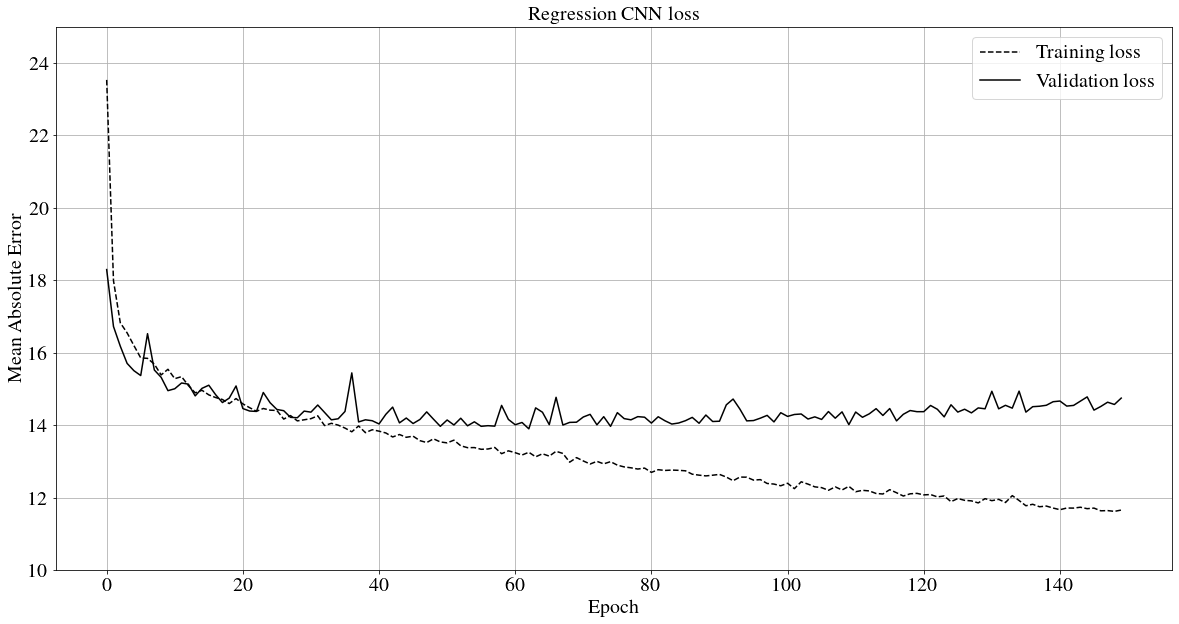

In [16]:
def plot_loss(history):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot()
    p1 = ax.plot(history.history['loss'], "--", color = "black")
    p2 = ax.plot(history.history['val_loss'], color = "black")
    ax.set_ylim([10, 25])
    ax.set_xlabel('Epoch', fontsize = 20)
    ax.set_ylabel('Mean Absolute Error', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(["Training loss", "Validation loss"], fontsize = 20)
    ax.grid(True)
    ax.set_title("Regression CNN loss", fontsize = 20)
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Times"
})
plot_loss(history)

In [17]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model_final')

2022-01-09 14:37:01.971430: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/my_model_final/assets


In [35]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [12]:
model = tf.keras.models.load_model('saved_model/my_model_final')

2022-01-09 19:08:41.917625: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-09 19:08:42.992469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6813 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [13]:
predicted = model.predict(test_data).reshape((test_data.shape[0],num_descriptors))

2022-01-09 19:08:43.498661: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 162180000 exceeds 10% of free system memory.
2022-01-09 19:08:43.610144: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 162180000 exceeds 10% of free system memory.
2022-01-09 19:08:45.401381: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


In [17]:
out_dict = dict()
out_dict["Descriptor"] = list()
out_dict["Average"] = list()

for d in descriptors:
    out_dict["Descriptor"].append(d)
    out_dict["Average"].append(df[d].mean(skipna = True)) # population mean for this descriptor

out_dict["Test Average"] = test_labels.mean(axis = 0)
out_dict["MAE"] = np.abs(test_labels-predicted).mean(axis = 0)

z_mae = (out_dict["MAE"] - out_dict["MAE"].mean())/out_dict["MAE"] - out_dict["MAE"].std()

mean_diff = np.abs(out_dict["Test Average"] - out_dict["Average"])
z_abs_mean_diff = (mean_diff - mean_diff.mean())/mean_diff.std()

Q = 1/z_mae + 1/z_abs_mean_diff
out_dict["Score"] = Q

pd.set_option("display.max_rows", None, "display.max_columns", None)
out_df = pd.DataFrame(data = out_dict)
print(out_dict["MAE"].sum()/74) # THIS IS WHAT tf.keras.losses.MeanAbsoluteError() DOES
out_df = out_df.sort_values("Score")
out_df

14.357384031430223

,Descriptor,Average,Test Average,MAE,Score
63,Molar Refractivity,95.559089,93.688508,19.137406,-82.404091
72,clogP;clogp_error,20.365517,18.705882,18.859663,-15.920477
64,Polarizability,37.783778,37.008772,7.707423,-3.659617
2,MOE Descriptors;h_ema,8.864515,8.089200,3.506953,-3.657621
50,Heavy Atom Count;Heavy Atom Count,25.426522,24.965039,5.318806,-2.880467
34,OEselma Descriptors;atom_count,25.429675,24.970033,5.780141,-2.877179
3,MOE Descriptors;h_emd,12.580101,12.200716,5.233711,-2.728971
42,OEselma Descriptors;polar_count,6.059067,5.694229,2.936765,-2.701110
35,OEselma Descriptors;bond_count,26.935092,26.614317,6.574783,-2.631138
6,MOE Descriptors;h_logs,9.838051,9.536647,2.399547,-2.595422


In [34]:
print(out_df.to_latex())

\begin{tabular}{llrrrr}
\toprule
{} &                                         Descriptor &     Average &  Test Average &      
MAE &     Score \\
\midrule
45 &                  OEselma Descriptors;silicon\_count &    0.004239 &      0.000555 &   
0.420973 &  0.009970 \\
43 &             OEselma Descriptors;polar\_count\_per\_mw &    0.016298 &      0.015985 &   
0.555143 &  0.028521 \\
20 &                   OEselma Descriptors;iodine\_count &    0.028450 &      0.022198 &   
0.593684 &  0.045730 \\
31 &          OEselma Descriptors;nonpolar\_count\_per\_mw &    0.031652 &      0.033783 &   
0.528322 &  0.056523 \\
10 &                  OEselma Descriptors;bromine\_count &    0.034856 &      0.032186 &   
0.486963 &  0.066798 \\
41 &              OEselma Descriptors;phosphorous\_count &    0.122751 &      0.115427 &   
0.630303 &  0.163004 \\
57 &                                AZlogD74;prediction &    0.608286 &      0.770768 &   
2.266315 &  0.211607 \\
12 &                  OEselma Descriptors;clorine\_count &    0.168629 &      0.164817 &   
0.622414 &  0.213173 \\
14 &                 OEselma Descriptors;fluorine\_count &    0.276967 &      0.263041 &   
0.865409 &  0.242448 \\
59 &                               ChromlogD;prediction &    1.046476 &      1.190575 &   
2.777749 &  0.273644 \\
9  &                               MOE Descriptors;h\_mr &    0.327136 &      0.287532 &   
0.784302 &  0.294336 \\
28 &                      OEselma Descriptors;neg\_ioniz &    0.539802 &      0.449501 &   
1.248762 &  0.301808 \\
46 &                  OEselma Descriptors;sulphur\_count &    0.289119 &      0.281354 &   
0.628956 &  0.314919 \\
19 &                  OEselma Descriptors;halogen\_count &    0.508902 &      0.482242 &   
1.046734 &  0.327135 \\
71 &                                        clogP;clogp &    1.655366 &      1.878574 &   
2.525918 &  0.395899 \\
44 &                      OEselma Descriptors;pos\_ioniz &    1.011211 &      0.964484 &   
1.264572 &  0.444335 \\
8  &                          MOE Descriptors;h\_log\_pbo &    1.932621 &      2.101887 &   
2.382856 &  0.447835 \\
0  &                               ACD Descriptors;logP &    2.055326 &      2.037895 &   
2.340647 &  0.467547 \\
1  &                                 ACD logD-logP;logP &    2.053207 &      2.037895 &   
2.277295 &  0.474127 \\
70 &    AZlogD74 (NN);nearest\_neighbours[]- GT measured &    1.637720 &      1.666410 &   
1.769427 &  0.480672 \\
23 &               OEselma Descriptors;max\_flex\_chain\_3 &    1.148954 &      1.185905 &   
1.224030 &  0.484181 \\
58 &                             AZlogD74;sd\_prediction &    0.729417 &      0.707592 &   
0.729823 &  0.499861 \\
67 &                    Solubility DD Class;credibility &    0.577961 &      0.575560 &   
0.549425 &  0.512656 \\
72 &                                  clogP;clogp\_error &   20.365517 &     18.705882 &  
18.859710 &  0.519194 \\
60 &                            ChromlogD;sd\_prediction &    0.806016 &      0.785463 &   
0.740526 &  0.521173 \\
61 &                                              ALogP &    2.202912 &      2.363989 &   
2.007240 &  0.523238 \\
22 &               OEselma Descriptors;max\_flex\_chain\_2 &    1.691916 &      1.760821 &   
1.341617 &  0.557738 \\
17 &                            OEselma Descriptors;hbd &    2.674517 &      2.533851 &   
2.080033 &  0.562517 \\
33 &            OEselma Descriptors;aromatic\_ring\_count &    1.607348 &      1.664262 &   
1.237209 &  0.565061 \\
69 &  AZlogD74 (NN);nearest\_neighbours[]- GT similarity &    0.628486 &      0.634556 &   
0.451486 &  0.581946 \\
29 &                 OEselma Descriptors;nitrogen\_count &    2.583797 &      2.562708 &   
1.782382 &  0.591775 \\
18 &                   OEselma Descriptors;hbd\_lipinski &    2.940744 &      2.791343 &   
2.004675 &  0.594640 \\
39 &                   OEselma Descriptors;oxygen\_count &    4.206029 &      3.945616 &   
2.567860 &  0.620918 \\
66 &           